In [233]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.special import gamma as gamma_fn
from matplotlib import rcParams as rc
import matplotlib as mpl
import matplotlib.cm as cm
from scipy.integrate import simps
import matplotlib.ticker as ticker
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

rc['legend.fontsize']=16
rc['axes.titlesize']=18
rc['axes.titlepad']=10
rc['lines.linewidth']=2
rc['lines.markersize']=6
rc['font.size']=18
rc['legend.handletextpad']= 0.2
rc['legend.frameon']=False
rc['text.usetex']=True
#print(rc.keys)

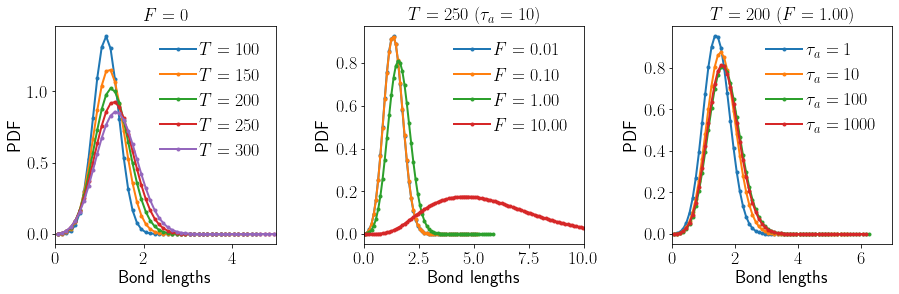

In [7]:
def Gamma_dist(x,k,theta):
    return x**(k-1)*np.exp(-x/theta)/(gamma_fn(k)*theta**k)

#plot bond lengths
fig,axes=plt.subplots(1,3,figsize=(15,4),gridspec_kw={'wspace':0.4, 'hspace':0.4,})
[ax1,ax2,ax3]=axes

# divider = make_axes_locatable(ax4)
# cax = divider.append_axes('right', size='5%', pad=0.05)
c=['C{}'.format(ii) for ii in range(10)]
ind=4
fpath='../../data/ROUSE_chainN100_confinedR0500/'
X,Y=[],[]
beta=[]
skew=[]
b_av=[]
b_sd=[]
i1,i2,i3=0,0,0
for fname in os.listdir(fpath):
    if 'bondlens' in fname:
        row=fname.split('_')
        T= float(row[ind].replace('T',''))
        F=float(row[ind+1].replace('F',''))
        Ta=float(row[ind+2].replace('Ta',''))
        kb=float(row[ind+7].replace('kb',''))
        Esoft=float(row[ind+3].replace('Esoft',''))
        R0=float(row[ind+4].replace('R0',''))
        dt=float(row[ind+8].replace('dt',''))
        
        data_npz=np.load(fpath+fname)

        # [k1,t1],pcov=curve_fit(Gamma_dist, data_npz['bins'],data_npz['hist'])
        
        if Ta==1. and F==0:
            ax1.plot(data_npz['bins'],data_npz['hist'],'.-', c=c[i1],label='$T={:.0f}$'.format(T))
            # ax1.plot(np.linspace(0,20,500), Gamma_dist(np.linspace(0,20,500), k1, t1), '-',c=c[i1])
            ax1.set_title('$F=0$')
            i1+=1

        if T==250. and Ta==10:
            ax2.plot(data_npz['bins'],data_npz['hist'],'.-', label='$F={:.2f}$'.format(F),c=c[i2])
            # ax2.plot(np.linspace(0,20,100), Gamma_dist(np.linspace(0,20,100), k1, t1), '-',c=c[i2])
            ax2.set_title('$T={:.0f}\ (\\tau_a={:.0f})$'.format(T, Ta))
            i2+=1
            
            
        if T==200. and F==1.0:
            ax3.plot(data_npz['bins'],data_npz['hist'],'.-', label='$\\tau_a={:.0f}$'.format(Ta),c=c[i3])
            # ax3.plot(np.linspace(0,20,100), Gamma_dist(np.linspace(0,20,100), k1, t1), '-',c=c[i3] )
            i3+=1
            ax3.set_title('$T={:.0f}\ (F={:.2f})$'.format(T, F))
            
            # print('skewness ', 2/np.sqrt(k1), ';mean', k1*t1)

ax1.set_xlim(0,5)
ax2.set_xlim(0,10)
ax3.set_xlim(0,7)
for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel('Bond lengths')
    ax.set_ylabel('PDF')
    # ax.set_xlim(1e-1,1e2)
    # ax.set_ylim(1e-5,5)

# fig.savefig('../../plots/Rouse/bond_lengths.png', dpi=300, bbox_inches='tight')


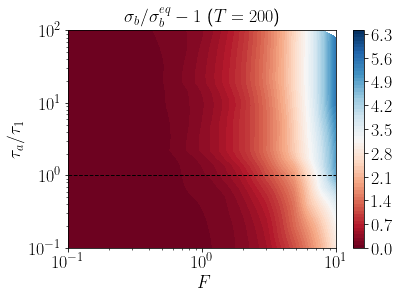

In [279]:
# divider = make_axes_locatable(ax4)
# cax = divider.append_axes('right', size='5%', pad=0.05)

ind=4
fpath='../../data/ROUSE_chainN100_confinedR0500/'
X,Y=[],[]
T0=200
skew=[]
b_av=[]
b_sd=[]
for fpath in ['../../data/ROUSE_chainN100_confinedR0500/']:
    for fname in os.listdir(fpath):
        if 'bondlens' in fname:
            row=fname.split('_')
            T= float(row[ind].replace('T',''))
            F=float(row[ind+1].replace('F',''))
            Ta=float(row[ind+2].replace('Ta',''))
            kb=float(row[ind+7].replace('kb',''))
            Esoft=float(row[ind+3].replace('Esoft',''))
            R0=float(row[ind+4].replace('R0',''))
            dt=float(row[ind+8].replace('dt',''))
            
            data_npz=np.load(fpath+fname)

            # [k1,t1],pcov=curve_fit(Gamma_dist, data_npz['bins'],data_npz['hist'])
            if kb==5: continue
            if T==T0:
                t1=1e4*0.1/(kb*np.pi**2)
                X.append(F)
                Y.append(Ta/t1)
                
                bond_len_av=simps(data_npz['hist']*data_npz['bins'],data_npz['bins'])
                bond_var=simps(data_npz['hist']*(data_npz['bins']-bond_len_av)**2,data_npz['bins'])
                b_sd.append(np.sqrt(bond_var))

                for feq in os.listdir(fpath):
                    if feq == fname.replace('_F{}_Ta{}_'.format(F,Ta),'_F0.0_Ta1.0_'):
                        data_eq=np.load(fpath+feq)
                        bond_len_eq=simps(data_eq['hist']*data_eq['bins'], data_eq['bins'])
                        bond_var_eq=simps(data_eq['hist']*(data_eq['bins']-bond_len_eq)**2,data_eq['bins'])

                b_av.append(np.sqrt(bond_var/bond_var_eq)-1)
                
                # skew.append( 2/np.sqrt(k1))


Xi,Yi=np.meshgrid(np.logspace(-2,1,30),np.logspace(-1,2,30))
triang=tri.Triangulation(X,Y)
interpZ=tri.LinearTriInterpolator(triang,b_av)#, kind='geom')
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi,levels=np.arange(0.,Zi.max()+1,0.1),cmap='RdBu')#,alpha=0.6)
        #ax.contour(Xi, Yi, Zi,colors='k',levels=levels,linewidths=0.3)
# plt.plot(X,Y, 'k.')
plt.semilogy()
# plt.loglog()
plt.colorbar()

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

ta,f=np.meshgrid(np.logspace(0,3.,100),np.logspace(-3,1,100))
bet=f**2*ta/(0.1*0.0083*100)
# cs=plt.contour(f, ta, bet,colors='w',levels=[1e3,1e4,1e5],linewidths=1)
# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)
plt.xlim(0.1,10)

plt.xlabel('$F$')
plt.ylabel('$\\tau_a/\\tau_1$')
plt.title('$\\sigma_b/\\sigma_b^{eq}-1$'+' ($T={}$)'.format(T0))

plt.loglog()
plt.ylim(1e-1,1e2)
plt.axhline(1,c='k', ls='--',lw=1)
# plt.legend(loc='upper right')

plt.savefig('../../plots/Rouse/T200_bond_sd_Ft.png', dpi=300, bbox_inches='tight')


Text(0.5, 0, 'Activity $F^2\\tau_a/(\\gamma T)$')

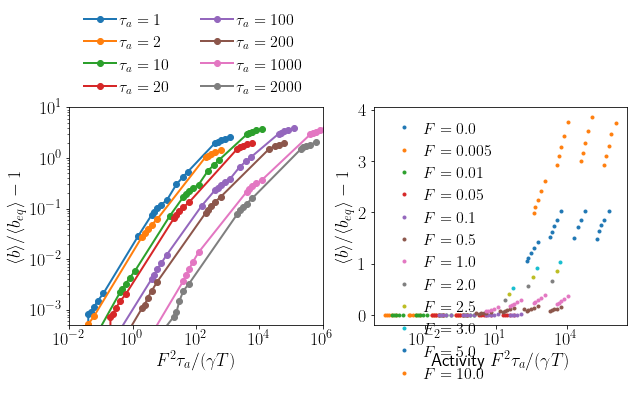

In [200]:
fig,[ax1,ax2]=plt.subplots(1,2, figsize=(10,4))

ind=4
fpath='../../data/ROUSE_chainN100_confinedR0500/N30/'
X,Y=[],[]

T0=300
Tas=[]
Fs=[]
bond_sd=[]
bond_av=[]


for fpath in ['../../data/ROUSE_chainN100_confinedR0500/']:

    for fname in os.listdir(fpath):
        if 'bondlens' in fname:
            row=fname.split('_')
            T= float(row[ind].replace('T',''))
            F=float(row[ind+1].replace('F',''))
            Ta=float(row[ind+2].replace('Ta',''))
            kb=float(row[ind+7].replace('kb',''))
            Esoft=float(row[ind+3].replace('Esoft',''))
            R0=float(row[ind+4].replace('R0',''))
            dt=float(row[ind+8].replace('dt',''))
            if kb==5: continue
            Tas.append(Ta)
            Fs.append(F)
            t1=1e4*0.1/(kb*np.pi**2)
            data_npz=np.load(fpath+fname)
            beta=F**2*Ta/(0.1*0.0083*T)
            bond_mean=simps(data_npz['hist']*data_npz['bins'], data_npz['bins'])
            # rg_sd=np.sqrt(simps((data_npz[par][1]-rg_mean)**2*data_npz[par][0], data_npz[par][1]))
            bond_eq=0
            # print(fname.replace('_F{}_Ta{}'.format(F,Ta),'_F0.0_Ta1.0_'))
            for feq in os.listdir(fpath):
                if feq == fname.replace('_F{}_Ta{}_'.format(F,Ta),'_F0.0_Ta1.0_'):
                    data_eq=np.load(fpath+feq)
                    bond_eq=simps(data_eq['hist']*data_eq['bins'], data_eq['bins'])
                
            bond_av.append((F,Ta,beta,bond_mean/bond_eq-1))

#plot rg ratio as function of activity
# rg_av=sorted(rg_av,key=lambda x: x[2])
for Ta in np.unique(Tas):

    bond_Ta=sorted([xx for xx in bond_av if xx[1]==Ta], key=lambda x:x[2])
    ax1.loglog([xx[2] for xx in bond_Ta],[xx[3] for xx in bond_Ta],'o-', label='$\\tau_a={:.0f}$'.format(Ta))
ax1.legend(loc='upper left',ncol=2,bbox_to_anchor=(0,1.5))
ax1.set_ylabel('$\\langle b\\rangle/\\langle b_{eq}\\rangle - 1$')
ax1.set_xlabel('$F^2\\tau_a/(\\gamma T)$')
ax1.set_ylim([5e-4,1e1])
ax1.set_xlim(1e-2,1e6)
# ax1.axhline(1,c='k',ls='--',lw=1)
ax1.set_yscale('Log')
# ax1.set_xscale('Log')

for F in np.unique(Fs):
    bond_F=sorted([xx for xx in bond_av if xx[0]==F], key=lambda x:x[2])
    ax2.semilogx([xx[2] for xx in bond_F],[xx[3] for xx in bond_F],'.', label='$F={}$'.format(F))
ax2.legend(loc='upper left')
ax2.set_ylabel('$\\langle b\\rangle/\\langle b_{eq}\\rangle - 1$')
ax2.set_xlabel('Activity $F^2\\tau_a/(\\gamma T)$')
# fig.savefig('../../plots/Rouse/bond_len_norm_fold_change.png', dpi=300, bbox_inches='tight')



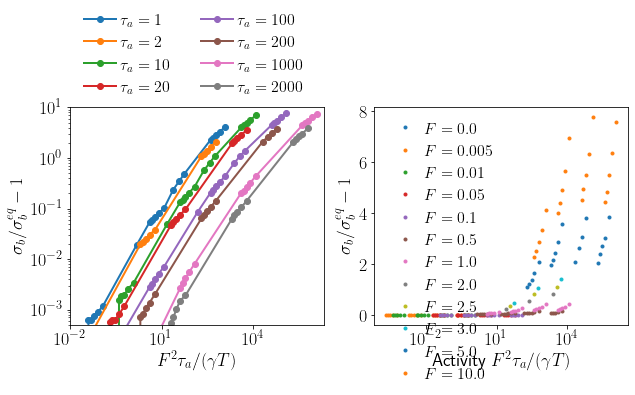

In [242]:
fig,[ax1,ax2]=plt.subplots(1,2, figsize=(10,4))

ind=4
fpath='../../data/ROUSE_chainN100_confinedR0500/N30/'
X,Y=[],[]

T0=300
Tas=[]
Fs=[]
bond_sd=[]
bond_av=[]


for fpath in ['../../data/ROUSE_chainN100_confinedR0500/']:

    for fname in os.listdir(fpath):
        if 'bondlens' in fname:
            row=fname.split('_')
            T= float(row[ind].replace('T',''))
            F=float(row[ind+1].replace('F',''))
            Ta=float(row[ind+2].replace('Ta',''))
            kb=float(row[ind+7].replace('kb',''))
            Esoft=float(row[ind+3].replace('Esoft',''))
            R0=float(row[ind+4].replace('R0',''))
            dt=float(row[ind+8].replace('dt',''))
            if kb==5: continue
            Tas.append(Ta)
            Fs.append(F)
            t1=1e4*0.1/(kb*np.pi**2)
            data_npz=np.load(fpath+fname)
            beta=F**2*Ta/(0.1*0.0083*T)
            bond_mean=simps(data_npz['hist']*data_npz['bins'], data_npz['bins'])
            sd=np.sqrt(simps((data_npz['bins']-bond_mean)**2*data_npz['hist'], data_npz['bins']))
            bond_eq=0
            # print(fname.replace('_F{}_Ta{}'.format(F,Ta),'_F0.0_Ta1.0_'))
            for feq in os.listdir(fpath):
                if feq == fname.replace('_F{}_Ta{}_'.format(F,Ta),'_F0.0_Ta1.0_'):
                    data_eq=np.load(fpath+feq)
                    bond_eq=simps(data_eq['hist']*data_eq['bins'], data_eq['bins'])
                    sd_eq=np.sqrt(simps((data_eq['bins']-bond_eq)**2*data_eq['hist'], data_eq['bins']))
                
            bond_av.append((F,Ta,beta,sd/sd_eq-1))

#plot rg ratio as function of activity
# rg_av=sorted(rg_av,key=lambda x: x[2])
for Ta in np.unique(Tas):

    bond_Ta=sorted([xx for xx in bond_av if xx[1]==Ta], key=lambda x:x[2])
    ax1.loglog([xx[2] for xx in bond_Ta],[xx[3] for xx in bond_Ta],'o-', label='$\\tau_a={:.0f}$'.format(Ta))
ax1.legend(loc='upper left',ncol=2,bbox_to_anchor=(0,1.5))
ax1.set_ylabel('$\\sigma_b/\\sigma_b^{eq} - 1$')
ax1.set_xlabel('$F^2\\tau_a/(\\gamma T)$')
ax1.set_ylim([5e-4,1e1])
ax1.set_xlim(1e-2,2e6)
# ax1.axhline(1,c='k',ls='--',lw=1)
ax1.set_yscale('Log')
# ax1.set_xscale('Log')

for F in np.unique(Fs):
    bond_F=sorted([xx for xx in bond_av if xx[0]==F], key=lambda x:x[2])
    ax2.semilogx([xx[2] for xx in bond_F],[xx[3] for xx in bond_F],'.', label='$F={}$'.format(F))
ax2.legend(loc='upper left')
ax2.set_ylabel('$\\sigma_b/\\sigma_b^{eq} - 1$')
ax2.set_xlabel('Activity $F^2\\tau_a/(\\gamma T)$')
fig.savefig('../../plots/Rouse/bond_sd_norm_fold_change.png', dpi=300, bbox_inches='tight')



In [49]:
30**2*0.1/(10*3.14**2)

0.9128159357377581